# Machine Learning with fraud dataset after using SageMaker Data Wrangler
#### Author: Alice Nguyen


In [16]:
#import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score c

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings("ignore")


According to CNBC (2016), consumers lost around 16B USD due to fraud transaction. Manual check cannot control the integrity of transactions and hence, ML could be utilised to assist banking industry. Now, let's load the data from S3 and see what we can do with ML to classify fraud transactions!

# 1. Load the transformed data from S3 bucket

*Data dictionary*: 

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount - amount of the transaction in local currency.

- nameOrig - customer who started the transaction

- oldbalanceOrg - initial balance before the transaction

- newbalanceOrig - new balance after the transaction

- nameDest - customer who is the recipient of the transaction

- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest - new balance recipient after the transaction. Note that there is no information for customers that start with M (Merchants).

- isFraud - These are the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers' accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.

In [3]:
s3uri="s3://sagemaker-ap-southeast-2-227284342025/DataWrangling1/part-00000-950274c2-7a9d-4d2f-b692-38de26d6435c-c000.csv"
df = pd.read_csv(s3uri)
df.head()

,step,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,isfraud,isflaggedfraud,type_CASH_OUT,type_TRANSFER,type_PAYMENT,type_CASH_IN,type_DEBIT
0,0.012129,0.000011,0.000000,0.000000,0.000000,0.000000,0,0,0.0,0.0,1.0,0.0,0.0
1,0.012129,0.000054,0.001211,0.001421,0.000000,0.000000,0,0,0.0,0.0,1.0,0.0,0.0
2,0.012129,0.004484,0.000000,0.000000,0.003462,0.004622,0,0,1.0,0.0,0.0,0.0,0.0
3,0.012129,0.000366,0.000705,0.000611,0.000000,0.000000,0,0,0.0,0.0,1.0,0.0,0.0
4,0.012129,0.000812,0.000000,0.000000,0.000547,0.000655,0,0,1.0,0.0,0.0,0.0,0.0


In [4]:
print("Number of rows in this dataset: ",df.shape[0])
print("Number of columns in this dataset: ",df.shape[1])

Number of rows in this dataset:  16426
Number of columns in this dataset:  13


In [6]:
#just a different way to check for null values in df
pprint(df.isnull().sum())

step              0
amount            0
oldbalanceorg     0
newbalanceorig    0
oldbalancedest    0
newbalancedest    0
isfraud           0
isflaggedfraud    0
type_CASH_OUT     0
type_TRANSFER     0
type_PAYMENT      0
type_CASH_IN      0
type_DEBIT        0
dtype: int64


In [8]:
# let's see the sample distributrion after sampling techniques
no_frauds = df[df['isfraud']==1].shape[0]
print("Number of fraud transaction in this dataset is: ", no_frauds)
Nprint("Percentage of number of frauds among all transactions:",(no_frauds/df.shape[0])*100,"%." )

Number of fraud transaction in this dataset is:  8213
Percentage of number of frauds among all transactions: 50.0 %.


Now, let's see if we have any correlation among independent variables in the dataset. Corellation can affect the performance of the model so we need to make decisions on dropping highly-correlated variables.

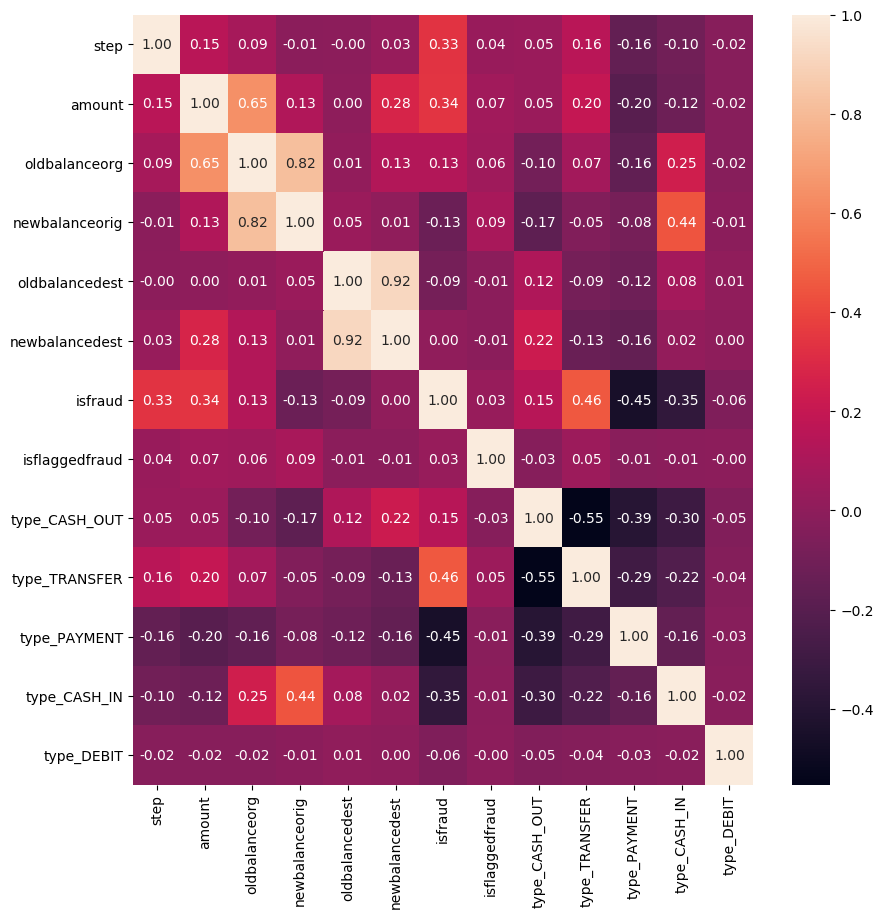

In [10]:
# plot heat map of correlations among features
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True, fmt='.2f')
plt.show()

From the heatmap, we can see that "oldbalancedest" and "newbalancedest" are strong corellated, so we will just keep either for our model. Similar for "oldbalanceorg" and "newbalanceorig".

In [11]:
df.drop(['newbalanceorig','newbalancedest'], axis = 1, inplace = True)

In [12]:
X=df.drop('isfraud',axis=1)
y=df['isfraud']

# # Splitting our data into training and testing dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

In [22]:
RANDOM_STATE=42

#experiements on different classification models to see which one performs better 
rf_model=RandomForestClassifier(random_state=RANDOM_STATE) #RandomForest classifier
mlp_model = MLPClassifier() #Multilayer Perceptron classifier
dt_model=DecisionTreeClassifier(random_state=RANDOM_STATE) #DecisionTree classifier
svc_model=SVC(kernel='linear',random_state=RANDOM_STATE) #Support Vector Machine classifier 
knn_model=KNeighborsClassifier() #KNN classifier 
xgboost_model = XGBClassifier() #XGBoost classifider 

model_dict = { 0: 'With Random Forest Classifier, ', 1: 'With MLP Classifier, ', 2:'With Decision Tree Classifier, ', 3:'With SVC Classifier, ', 4:'With KNN Classifier, ', 5:'With XGBoost Classifier, '}
models=[rf_model,mlp_model, dt_model, svc_model, knn_model,xgboost_model]

for i, model in enumerate(models):
    print("{} test accuracy achieves {}%.".format(model_dict[i],cross_val_score(model, X_train, y_train, cv=10, scoring ='accuracy').mean()*100))


With Random Forest Classifier,  test accuracy achieves 98.54753093427178%.
With MLP Classifier,  test accuracy achieves 93.39869830098007%.
With Decision Tree Classifier,  test accuracy achieves 98.19962159912212%.
With SVC Classifier,  test accuracy achieves 83.47526393461233%.
With KNN Classifier,  test accuracy achieves 93.38138267680782%.
With XGBoost Classifier,  test accuracy achieves 99.0084988837174%.


3 top performance model: XGBoost , Random Forest, and Decision Tree. 

Now let's pick the top 1 and do more evaluation.

In [23]:
xgboost_model.fit(X_train, y_train)
y_pred = xgboost_model.predict(X_test)

print("Model evaluation: ")
print(classification_report(y_test, y_pred, target_names=['Not Fraud','Fraud']))

Model evaluation: 
              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      0.99      2435
       Fraud       0.99      1.00      0.99      2493

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



# Summary

Some key points from my work leveraging SageMaker to build:

    - Data wrangling pipeline: a reusable template with steps:
    
        + Correct data types.
        + Drop unnecessary columns like name.
        + Hot encoding categorical variables.
        + Data normalisation. 
        
    - Prediction models using 5 different classifiers. The winner is XGBoost with 99% accuracy with good precision/recall/f1 as well. 
    
Suggestion for further work: train on larger dataset and test on other dataset with the same distribution to see how generalised the model is. 
     